<a href="https://colab.research.google.com/github/hyeonji0401/CUDA_practice/blob/main/CUDA_based_matrix_multiplication_program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7.1 행렬곱셈이란?
- 행렬 A 크기가 m * n, B의 크기가 k * n일때 행렬 C의 크기는 m*n이 됨
- 본 장에서 작성하고자 하는 행렬 곱셈 프로그램은 하나의 스레드 블록으로 처리할 수 없는 대규모 행렬의 연산을 목적으로 함(m,n,k의 각 크기가 256이상인 경우

In [ ]:
%%cuda
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <chrono>
#include <iostream>

#define DO_CPU
#define DATA_TYPE int

#define SIZE_M (512*2)
#define SIZE_N (512*4)
#define SIZE_K (512*2)

template<class T> void allocNinitMem(T** p, long long size, double* memUsage = NULL);
bool compareMatrix(DATA_TYPE* _A, DATA_TYPE* _B, int _size);

/******************************************************************
* Complete this kernels
******************************************************************/
__global__ void MatMul(DATA_TYPE* matA, DATA_TYPE* matB, DATA_TYPE* matC, int m, int n, int k)
{
  unsigned int row = blockIdx.x*blockDim.x+threadIdx.x;
  unsigned int col = blockIdx.y*blockDim.y+threadIdx.y;

	if(col>=n||row>=m) return;
	DATA_TYPE val = 0;
  for(int i=0; i<k; i++){
      val+=matA[row*k+i]*matB[i*n+col];
  }
	matC[row*n + col] = val;

}


int main(int argc, char* argv[])
{

	// set matrix size
	int m, n, k;
	m = SIZE_M;
	n = SIZE_N;
	k = SIZE_K;

	printf("Size : A = (%d by %d), B = (%d by %d), C = (%d by %d)\n", m, k, k, n, m, n);

	int sizeA = m * k;
	int sizeB = k * n;
	int sizeC = m * n;

	// Make matrix
	DATA_TYPE* A = NULL, * B = NULL;
	allocNinitMem<DATA_TYPE>(&A, sizeA);
	allocNinitMem<DATA_TYPE>(&B, sizeB);

	DATA_TYPE* Ccpu = NULL, * Cgpu = NULL;
	allocNinitMem<DATA_TYPE>(&Ccpu, sizeC);
	allocNinitMem<DATA_TYPE>(&Cgpu, sizeC);

	// generate input matrices
	for (int i = 0; i < sizeA; i++) A[i] = ((rand() % 10) + ((rand() % 100) / 100.0));
	for (int i = 0; i < sizeB; i++) B[i] = ((rand() % 10) + ((rand() % 100) / 100.0));

	// CPU algorithm
	auto hostStart = std::chrono::high_resolution_clock::now();
	for (int row = 0; row < m; row++) {
		for (int col = 0; col < n; col++) {
			int cIndex = row * n + col;
			Ccpu[cIndex] = 0;
			for (int i = 0; i < k; i++)
				Ccpu[cIndex] += (A[row * k + i] * B[i * n + col]);
		}
	}
	printf("CPU finished!\n");
	auto hostEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> hostElapsed = hostEnd - hostStart;

	/******************************************************************
	* Write your codes for GPU algorithm from here
	******************************************************************/
	DATA_TYPE* dA, * dB, * dC;

	// 1. Allocate device memory for dA, dB, dC
	// Hint: cudaMalloc, cudaMemset
  cudaMalloc(&dA, sizeof(DATA_TYPE)*sizeA); cudaMemset(dA, 0, sizeof(DATA_TYPE)*sizeA);
  cudaMalloc(&dB, sizeof(DATA_TYPE)*sizeB); cudaMemset(dB, 0, sizeof(DATA_TYPE)*sizeB);
  cudaMalloc(&dC, sizeof(DATA_TYPE)*sizeC); cudaMemset(dC, 0, sizeof(DATA_TYPE)*sizeC);
	auto GPUStart = std::chrono::high_resolution_clock::now();

	auto h2dStart = std::chrono::high_resolution_clock::now();

	// 2. Send(Copy) the input matrices to GPU (A -> dB, B -> dB)
	// Hint: cudaMemcpy
  cudaMemcpy(dA, A, sizeof(DATA_TYPE)*sizeA, cudaMemcpyHostToDevice);
  cudaMemcpy(dB, B, sizeof(DATA_TYPE)*sizeB, cudaMemcpyHostToDevice);

	auto h2dEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> h2dElapsed = h2dEnd - h2dStart;

	// 3. Set the thread layout
	//
	dim3 gridDim(ceil((float)SIZE_M/32), ceil((float)SIZE_N/32));
	dim3 blockDim(32, 32);

	printf("Grid(%d, %d), Block(%d, %d)\n", gridDim.x, gridDim.y, blockDim.x, blockDim.y);

	auto kernelStart = std::chrono::high_resolution_clock::now();

	// 4. Kernel call
	MatMul <<< gridDim, blockDim >>> (dA, dB, dC, m, n, k);

	cudaDeviceSynchronize(); // this is synchronization for mearusing the kernel processing time
	auto kernelEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> kernelElapsed = kernelEnd - kernelStart;

	auto d2hStart = std::chrono::high_resolution_clock::now();

	//5. Get(copy) the result from GPU to host memory (dC -> Cgpu)
	// Hint: cudaMemcpy
  cudaMemcpy(Cgpu, dC, sizeC* sizeof(DATA_TYPE), cudaMemcpyDeviceToHost);

	auto d2hEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> d2hElapsed = d2hEnd - d2hStart;

 auto GPUEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> GPUElapsed = GPUEnd - GPUStart;

  std::cout << "Host time: " << hostElapsed.count() << " ms" << std::endl;
  std::cout<<"Host -> Device: " << h2dElapsed.count() << " ms" << std::endl;
  std::cout<<"Kernel: " << kernelElapsed.count() << " ms" << std::endl;
  std::cout<<"Device -> Host: " << d2hElapsed.count() << " ms" << std::endl;
  std::cout << "GPU time: " << GPUElapsed.count() << " ms" << std::endl;
	// 6. Release device memory space (dA, dB, dC)
	// Hint: cudaFree
  cudaFree(dA);
  cudaFree(dB);
  cudaFree(dC);


	/******************************************************************
	******************************************************************/


	compareMatrix(Ccpu, Cgpu, sizeC);

	delete A;
	delete B;
	delete Ccpu;
	delete Cgpu;

	return 0;
}


// Utility functions
bool compareMatrix(DATA_TYPE* _A, DATA_TYPE* _B, int _size)
{
	bool isMatched = true;
	for (int i = 0; i < _size; i++) {
		if (_A[i] != _B[i]) {
			printf("[%d] not matched! (%f, %f)\n", i, (double)_A[i], (double)_B[i]);
			getchar();
			isMatched = false;
		}
	}
	if (isMatched)
		printf("Results are matched!\n");
	else
		printf("Results are not matched!!!!!!!!!!!\n");

	return isMatched;
}

template<class T>
void allocNinitMem(T** p, long long size, double* memUsage) {
	*p = new T[size];
	memset(*p, 0, sizeof(T) * size);

	if (memUsage != NULL) {
		*memUsage += sizeof(T) * size;
	}
}

Size : A = (1024 by 1024), B = (1024 by 2048), C = (1024 by 2048)
CPU finished!
Grid(32, 64), Block(32, 32)
Host time: 23996.7 ms
Host -> Device: 2.92826 ms
Kernel: 178.807 ms
Device -> Host: 2.10433 ms
GPU time: 183.843 ms
Results are matched!



\

# 오답 노트



```
dim3 gridDim(ceil((float)SIZE_M/32), ceil((float)SIZE_N/32));
```
- 인자는 순서대로 X,Y,Z를 나타냄
- M은 결과 행렬의 행이고 N은 결과 행렬의 열이므로 커널 코드에서 row에는 X차원과 매칭하고 col에는 Y차원과 매칭하면 됨
- 인자 순서가 바뀔 경우 커널 코드에서도 반대로 매칭해야함
- SIZE_M 앞의 캐스트 연산자는 올림을 하기 위한 것으로 꼭 필요함



```
matC[index]=0;
```
- 행렬의 합을 담을 것이므로 혹시 모를 쓰레기 값을 대비하여 초기화해주는 것이 중요함



```
cudaMemcpy(Cgpu, dC, sizeC* sizeof(DATA_TYPE), cudaMemcpyDeviceToHost);
```
- 값을 옮길 때 sizeof(DATA_TYPE)을 해주지 않아 결과가 항상 맞지 않았음
- 빼먹은 걸 뒤늦게 찾아서 시간을 많이 소모함
- 데이터 크기를 올바르게 설정해야 올바른 크키대로 복사되어 올바른 비교를 할 수 있으므로 주의 할 것





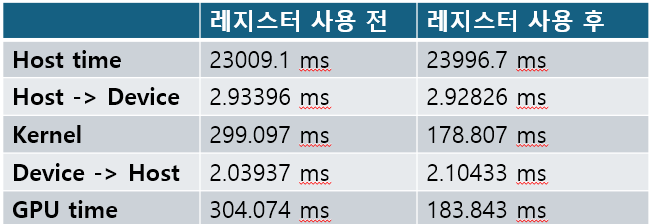



```
DATA_TYPE val = 0;
  for(int i=0; i<k; i++){
      val+=matA[row*k+i]*matB[i*n+col];
  }
	matC[row*n + col] = val;
```



- 레지스터 사용 후와 전의 커널 시간이 많이 차이나는 것을 확인할 수 있음

# 7.2 스레드 레이아웃 설정
1.데이터를 읽는 행렬 A,B 기준
- 읽기 연산의 반복

1) 행렬 A의 각 행 또는 행렬 B에서 각 열을 하나의 스레드가 처리하게 하는 것
- 병렬 처리에 참여할 수 있는 스레드의 수가 행렬 A의 행 개수 또는 행렬 B의 열 개수로 제한됨

  => 병렬 처리 정도(degree of parallelism)가 낮아짐
- GPU 병렬 처리 능력을 최대한 활용하려면 많은 스레드를 사용하는 것이 중요하므로 입력 행렬 중 하나만을 기준으로 삼는 레이아웃

2) 두 입력 행렬을 동시에 고려
- 모든 A와 B 쌍의 곱을 동시에 병렬로 처리
- m * n * k 스레드를 사용하게 됨
- 행렬의 C입장에서 보면 여러 개의 스레드가 동시에 접근해서 갱신해야하는 상황이 발생함
 - 동기화 문제 발생 ( 여러 스레드가 쓰기 연산 시 이상한 값 생성 가능성)
 - 해결을 위해 동기화 기법 사용시 직렬화되어 성능이 떨어짐
2.결과가 저장되는 행렬 C 기준
- 쓰기 연산의 반복
- 쓰기 연산에는 동기화 문제가 발생하므로 쓰기 영역을 분할하여 스레드들에게 분배하는 방법
 - 행렬 C의 각 원소를 스레드들에게 분배
 - 동시 접근은 읽기 연산에서만 발생

 => 행렬은 2차원 데이터로 레이아웃 또한 2차원으로 잡는 것이 일반적임





# 7.3 스레드 인덱싱
- C를 기준으로 스레드 레이아웃을 설정함에 따라 각 스레드가 접근해야 하는 데이터는 다음과 같음

1) 결과 행렬 C 중 자신(스레드)이 담당하는 원소

2) 담당하는 C의 원소를 계산하기 위한 입력 행렬 A의 한 행과 B의 한 열

1.행렬 C의 크기가 블록 최대 크기(1,024)보다 작은 경우

**가. C(row, col)에 대한 인덱싱**
- 행렬 C와 크기가 동일한 2차원 스레드 레이아웃을 사용하기 때문에, 각 스레드가 담당하는 원소 C(rwo, col)에 대한 인덱스는 스레드 번호를 사용하여 간단히 지정가능
 - row = threadIdx.x
 - col = threadIdx.y
- 메모리 상의 C(row, col) 위치는 row, col 값과 행렬 C의 행 길이(n)을 이용해서 계산할 수 있다
 - index = row * blockDIm.y(n) + col

**나. 입력 행렬 A,B에 대한 인덱싱**
- A(row, offset)와 B(offset, col)에 접근해야함(offset = 0,1,,,k)
 - A(row, offset) = row * k + offset
 - B(offset, col) = col + (offset * n)
  - row * k 는 row번째 행의 첫번째 원소를 가리키게 됨
  - n * offset 는 offset-번째 행의 col번째 첫번째 원소를 가리키게 됨

2.행렬 C의 크기가 블록의 최대 크기(1,024)보다 큰 경우

**가. C(row, col)에 대한 인덱싱**
- 여러 개의 블록을 사용하는 경우 스레드의 전역 번호(global ID)를 사용해야함
 - row = (blockDim.x * blockIdx.x) + threadIdx.x
 - col = (blockDim.y * blockIdx.y) + threadIdx.y

# 7.4 구현 및 성능 평가
- 다음은 교재 저자가 작성한 코드임


In [4]:
%%cuda
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <chrono>
#include <iostream>

#define DO_CPU
#define DATA_TYPE int

#define SIZE_M (512*2)
#define SIZE_N (512*4)
#define SIZE_K (512*2)

#define INDEX2ROW(_index,_width)	(int)((_index)/(_width))
#define INDEX2COL(_index,_width)	((_index)%(_width))
#define ID2INDEX(_row,_col, _width) (((_row)*(_width))+(_col))

#define BLOCK_SIZE 8

//Macro function
//#define KERNEL_MUL(_a,_b) __fmul_rn(_a,_b)
#define KERNEL_MUL(_a,_b) (_a*_b)

// kernel declarations
__global__ void MatMul(DATA_TYPE* matA, DATA_TYPE* matB, DATA_TYPE* matC, int m, int n, int k);

template<class T> void allocNinitMem(T** p, long long size, double* memUsage = NULL);
bool compareMatrix(DATA_TYPE* _A, DATA_TYPE* _B, int _size);

int main(int argc, char* argv[])
{


	// set matrix size
	int m, n, k;

	if (argc < 3) { m = SIZE_M;	n = SIZE_N;	k = SIZE_K; }
	else { m = atoi(argv[1]);	n = atoi(argv[2]);	k = atoi(argv[3]); }

	printf("Size : A = (%d by %d), B = (%d by %d), C = (%d by %d)\n", m, k, k, n, m, n);

	int sizeA = m * k;
	int sizeB = k * n;
	int sizeC = m * n;

	// Make matrix
	DATA_TYPE* A = NULL, * B = NULL;
	allocNinitMem<DATA_TYPE>(&A, sizeA);
	allocNinitMem<DATA_TYPE>(&B, sizeB);

	DATA_TYPE* Ccpu = NULL, * Cgpu = NULL;
	allocNinitMem<DATA_TYPE>(&Ccpu, sizeC);
	allocNinitMem<DATA_TYPE>(&Cgpu, sizeC);

	// generate input matrices
	for (int i = 0; i < sizeA; i++) A[i] = ((rand() % 10) + ((rand() % 100) / 100.0));
	for (int i = 0; i < sizeB; i++) B[i] = ((rand() % 10) + ((rand() % 100) / 100.0));

#ifdef DO_CPU // CPU version (OpenMP)
auto hostStart = std::chrono::high_resolution_clock::now();
//#pragma omp parallel for num_threads(4)
	for (int row = 0; row < m; row++) {
		for (int col = 0; col < n; col++) {
			int cIndex = ID2INDEX(row, col, n);
			Ccpu[cIndex] = 0;
			for (int i = 0; i < k; i++)
				Ccpu[cIndex] += (A[ID2INDEX(row, i, k)] * B[ID2INDEX(i, col, n)]);
		}
	}
	printf("CPU finished!\n");
	auto hostEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> hostElapsed = hostEnd - hostStart;
#endif

	// GPU setup
	DATA_TYPE* dA, * dB, * dC;

	cudaMalloc(&dA, sizeA * sizeof(DATA_TYPE));
	cudaMemset(dA, 0, sizeA * sizeof(DATA_TYPE));

	cudaMalloc(&dB, sizeB * sizeof(DATA_TYPE));
	cudaMemset(dB, 0, sizeB * sizeof(DATA_TYPE));

	cudaMalloc(&dC, sizeC * sizeof(DATA_TYPE));
	cudaMemset(dC, 0, sizeC * sizeof(DATA_TYPE));

	auto GPUStart = std::chrono::high_resolution_clock::now();

	auto h2dStart = std::chrono::high_resolution_clock::now();
	cudaMemcpy(dA, A, sizeA * sizeof(DATA_TYPE), cudaMemcpyHostToDevice);
	cudaMemcpy(dB, B, sizeB * sizeof(DATA_TYPE), cudaMemcpyHostToDevice);
	auto h2dEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> h2dElapsed = h2dEnd - h2dStart;

	dim3 gridDim(ceil((float)m / BLOCK_SIZE), ceil((float)n / BLOCK_SIZE));
	dim3 blockDim(BLOCK_SIZE, BLOCK_SIZE);

	printf("Grid(%d, %d), Block(%d, %d)\n", gridDim.x, gridDim.y, blockDim.x, blockDim.y);

	// GPU version
	auto kernelStart = std::chrono::high_resolution_clock::now();
	MatMul << < gridDim, blockDim >> > (dA, dB, dC, m, n, k);
	cudaDeviceSynchronize();
	auto kernelEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> kernelElapsed = kernelEnd - kernelStart;

	auto d2hStart = std::chrono::high_resolution_clock::now();
	cudaMemcpy(Cgpu, dC, sizeC * sizeof(DATA_TYPE), cudaMemcpyDeviceToHost);
	auto d2hEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> d2hElapsed = d2hEnd - d2hStart;

	auto GPUEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> GPUElapsed = GPUEnd - GPUStart;

  std::cout << "Host time: " << hostElapsed.count() << " ms" << std::endl;
  std::cout<<"Host -> Device: " << h2dElapsed.count() << " ms" << std::endl;
  std::cout<<"Kernel: " << kernelElapsed.count() << " ms" << std::endl;
  std::cout<<"Device -> Host: " << d2hElapsed.count() << " ms" << std::endl;
  std::cout << "GPU time: " << GPUElapsed.count() << " ms" << std::endl;

	cudaFree(dA);
	cudaFree(dB);
	cudaFree(dC);

#ifdef DO_CPU
	printf("[Kernel basic] ");
	compareMatrix(Ccpu, Cgpu, sizeC);
#endif

	delete A;
	delete B;
	delete Ccpu;
	delete Cgpu;

	return 0;
}

bool compareMatrix(DATA_TYPE* _A, DATA_TYPE* _B, int _size)
{
	bool isMatched = true;
	for (int i = 0; i < _size; i++) {
		if (_A[i] != _B[i]) {
			printf("[%d] not matched! (%f, %f)\n", i, _A[i], _B[i]);
			getchar();
			isMatched = false;
		}
	}
	if (isMatched)
		printf("Results are matched!\n");
	else
		printf("Results are not matched!!!!!!!!!!!\n");

	return isMatched;
}

__global__ void MatMul(DATA_TYPE* matA, DATA_TYPE* matB, DATA_TYPE* matC, int m, int n, int k)
{
	int row = blockDim.x * blockIdx.x + threadIdx.x;
	int col = blockDim.y * blockIdx.y + threadIdx.y;

	if (row >= m || col >= n)
		return;

	DATA_TYPE val = 0; // hope to use register
	for (int i = 0; i < k; i++)
		val += matA[row*k+i] * matB[col+i*n];

	matC[row * n + col] = val;
}

template<class T>
void allocNinitMem(T** p, long long size, double* memUsage) {
	*p = new T[size];
	memset(*p, 0, sizeof(T) * size);

	if (memUsage != NULL) {
		*memUsage += sizeof(T) * size;
	}
}

Size : A = (1024 by 1024), B = (1024 by 2048), C = (1024 by 2048)
CPU finished!
Grid(128, 256), Block(8, 8)
Host time: 21571.3 ms
Host -> Device: 2.93992 ms
Kernel: 52.069 ms
Device -> Host: 1.98045 ms
GPU time: 56.9935 ms
[Kernel basic] Results are matched!



- 스레드 블록은 커널의 성능에 영향을 주며, 적절한 크기는 알고리즘 및 GPU에 따라 달라질 수 있음
- BLOCK_SIZE를 8, 16, 32 등으로 바꾸어 성능 크기를 측정해보자

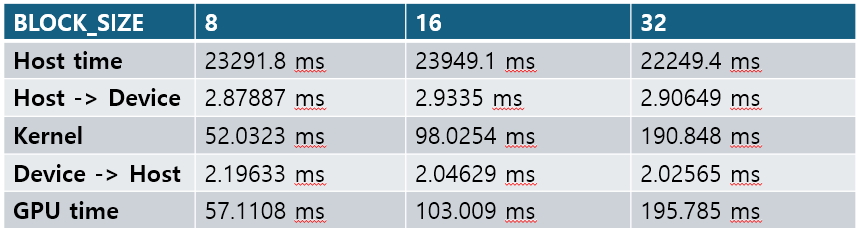

- 블록 크기가 작을 수록 성능이 좋아지는 것을 확인할 수 있었음


3.부동소수점 연산 정밀도 문제
- 앞서 작성한 프로그램을 행렬의 원소가 float형의 실수를 가지도록 수정


In [5]:
%%cuda
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <chrono>
#include <iostream>

#define DO_CPU
#define DATA_TYPE float

#define SIZE_M (512*2)
#define SIZE_N (512*4)
#define SIZE_K (512*2)

template<class T> void allocNinitMem(T** p, long long size, double* memUsage = NULL);
bool compareMatrix(DATA_TYPE* _A, DATA_TYPE* _B, int _size);

/******************************************************************
* Complete this kernels
******************************************************************/
__global__ void MatMul(DATA_TYPE* matA, DATA_TYPE* matB, DATA_TYPE* matC, int m, int n, int k)
{
  unsigned int row = blockIdx.x*blockDim.x+threadIdx.x;
  unsigned int col = blockIdx.y*blockDim.y+threadIdx.y;

	if(col>=n||row>=m) return;
	DATA_TYPE val = 0;
  for(int i=0; i<k; i++){
      val+=matA[row*k+i]*matB[i*n+col];
  }
	matC[row*n + col] = val;

}


int main(int argc, char* argv[])
{

	// set matrix size
	int m, n, k;
	m = SIZE_M;
	n = SIZE_N;
	k = SIZE_K;

	printf("Size : A = (%d by %d), B = (%d by %d), C = (%d by %d)\n", m, k, k, n, m, n);

	int sizeA = m * k;
	int sizeB = k * n;
	int sizeC = m * n;

	// Make matrix
	DATA_TYPE* A = NULL, * B = NULL;
	allocNinitMem<DATA_TYPE>(&A, sizeA);
	allocNinitMem<DATA_TYPE>(&B, sizeB);

	DATA_TYPE* Ccpu = NULL, * Cgpu = NULL;
	allocNinitMem<DATA_TYPE>(&Ccpu, sizeC);
	allocNinitMem<DATA_TYPE>(&Cgpu, sizeC);

	// generate input matrices
	for (int i = 0; i < sizeA; i++) A[i] = ((rand() % 10) + ((rand() % 100) / 100.0));
	for (int i = 0; i < sizeB; i++) B[i] = ((rand() % 10) + ((rand() % 100) / 100.0));

	// CPU algorithm
	auto hostStart = std::chrono::high_resolution_clock::now();
	for (int row = 0; row < m; row++) {
		for (int col = 0; col < n; col++) {
			int cIndex = row * n + col;
			Ccpu[cIndex] = 0;
			for (int i = 0; i < k; i++)
				Ccpu[cIndex] += (A[row * k + i] * B[i * n + col]);
		}
	}
	printf("CPU finished!\n");
	auto hostEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> hostElapsed = hostEnd - hostStart;

	/******************************************************************
	* Write your codes for GPU algorithm from here
	******************************************************************/
	DATA_TYPE* dA, * dB, * dC;

	// 1. Allocate device memory for dA, dB, dC
	// Hint: cudaMalloc, cudaMemset
  cudaMalloc(&dA, sizeof(DATA_TYPE)*sizeA); cudaMemset(dA, 0, sizeof(DATA_TYPE)*sizeA);
  cudaMalloc(&dB, sizeof(DATA_TYPE)*sizeB); cudaMemset(dB, 0, sizeof(DATA_TYPE)*sizeB);
  cudaMalloc(&dC, sizeof(DATA_TYPE)*sizeC); cudaMemset(dC, 0, sizeof(DATA_TYPE)*sizeC);
	auto GPUStart = std::chrono::high_resolution_clock::now();

	auto h2dStart = std::chrono::high_resolution_clock::now();

	// 2. Send(Copy) the input matrices to GPU (A -> dB, B -> dB)
	// Hint: cudaMemcpy
  cudaMemcpy(dA, A, sizeof(DATA_TYPE)*sizeA, cudaMemcpyHostToDevice);
  cudaMemcpy(dB, B, sizeof(DATA_TYPE)*sizeB, cudaMemcpyHostToDevice);

	auto h2dEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> h2dElapsed = h2dEnd - h2dStart;

	// 3. Set the thread layout
	//
	dim3 gridDim(ceil((float)SIZE_M/32), ceil((float)SIZE_N/32));
	dim3 blockDim(32, 32);

	printf("Grid(%d, %d), Block(%d, %d)\n", gridDim.x, gridDim.y, blockDim.x, blockDim.y);

	auto kernelStart = std::chrono::high_resolution_clock::now();

	// 4. Kernel call
	MatMul <<< gridDim, blockDim >>> (dA, dB, dC, m, n, k);

	cudaDeviceSynchronize(); // this is synchronization for mearusing the kernel processing time
	auto kernelEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> kernelElapsed = kernelEnd - kernelStart;

	auto d2hStart = std::chrono::high_resolution_clock::now();

	//5. Get(copy) the result from GPU to host memory (dC -> Cgpu)
	// Hint: cudaMemcpy
  cudaMemcpy(Cgpu, dC, sizeC* sizeof(DATA_TYPE), cudaMemcpyDeviceToHost);

	auto d2hEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> d2hElapsed = d2hEnd - d2hStart;

 auto GPUEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> GPUElapsed = GPUEnd - GPUStart;

  std::cout << "Host time: " << hostElapsed.count() << " ms" << std::endl;
  std::cout<<"Host -> Device: " << h2dElapsed.count() << " ms" << std::endl;
  std::cout<<"Kernel: " << kernelElapsed.count() << " ms" << std::endl;
  std::cout<<"Device -> Host: " << d2hElapsed.count() << " ms" << std::endl;
  std::cout << "GPU time: " << GPUElapsed.count() << " ms" << std::endl;
	// 6. Release device memory space (dA, dB, dC)
	// Hint: cudaFree
  cudaFree(dA);
  cudaFree(dB);
  cudaFree(dC);


	/******************************************************************
	******************************************************************/


	compareMatrix(Ccpu, Cgpu, sizeC);

	delete A;
	delete B;
	delete Ccpu;
	delete Cgpu;

	return 0;
}


// Utility functions
bool compareMatrix(DATA_TYPE* _A, DATA_TYPE* _B, int _size)
{
	bool isMatched = true;
	for (int i = 0; i < _size; i++) {
		if (_A[i] != _B[i]) {
			printf("[%d] not matched! (%f, %f)\n", i, (double)_A[i], (double)_B[i]);
			getchar();
			isMatched = false;
		}
	}
	if (isMatched)
		printf("Results are matched!\n");
	else
		printf("Results are not matched!!!!!!!!!!!\n");

	return isMatched;
}

template<class T>
void allocNinitMem(T** p, long long size, double* memUsage) {
	*p = new T[size];
	memset(*p, 0, sizeof(T) * size);

	if (memUsage != NULL) {
		*memUsage += sizeof(T) * size;
	}
}

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[431183] not matched! (26756.919922, 26756.921875)
[431187] not matched! (25757.539062, 25757.537109)
[431191] not matched! (25320.294922, 25320.292969)
[431193] not matched! (25843.652344, 25843.650391)
[431194] not matched! (25424.591797, 25424.593750)
[431195] not matched! (25550.128906, 25550.130859)
[431203] not matched! (25395.757812, 25395.755859)
[431209] not matched! (25400.099609, 25400.101562)
[431211] not matched! (24780.117188, 24780.115234)
[431212] not matched! (25654.240234, 25654.242188)
[431216] not matched! (24977.257812, 24977.259766)
[431217] not matched! (25591.892578, 25591.890625)
[431218] not matched! (26197.574219, 26197.572266)
[431220] not matched! (25372.585938, 25372.587891)
[431221] not matched! (26064.265625, 26064.267578)
[431222] not matched! (26372.931641, 26372.929688)
[431231] not matched! (25597.324219, 25597.322266)
[431232] not matched! (25432.863281, 25432.861328)
[431235] not matched! (25094.173828, 25094.171

KeyboardInterrupt: 

- 부동 소수점 표현법이 가지는 정밀도의 한계에서 발생하는 오류

**부동소수점**
- 가수부(fraction), 지수부(exponent)로 이루어져있음
- 가수부가 정확하게 표현할 수 있는 유효 숫자는 가수부에 할당된 비트 수에 따라 제한됨
- 계산 과정 중 소수점 아주 작은 수처럼 유효숫자의 범위를 벗어나는 경우, 유효숫자 범위로 수를 맞추는 과정(라운딩 : rounding)을 거치게 됨
 - 올림, 내림, 반올림, 버림 등의 전략이 있으며, 하드웨어마다 다를 수 있음

=>이러한 오차가 누적됨에 따라 CPU 계산 값과 GPU 계산 값 사이에 차이가 발생할 수 있음

- 해결방안
 - 허용 가능한 오차 범위 설정
   - float의 유효숫자는 일반적으로 소수점 여섯째 자리라는 점을 이용하여 두 수의 차이가 10^-5보다 작은 경우 같은 숫자로 인정하는 방법
   - 연산 과정이 복잡하면 오차가 계속 누적되어 근본적인 해결방법은 아님
 - 정밀도가 더 높은 자료형을 사용하는 것
   - float대신 double을 사용하면 더 높은 계산 정밀도를 확보할 수있음
   - 그러나 이 경우도 유효숫자를 벗어나면 차이가 날 수 있으므로 첫번째 방식과 함께 사용하는 것이 좋음
 - 숫자 라운딩 전략 직접 지정
   - CUDA는 사용자가 라운딩 전략을 직접 지정할 수 있는 API를 제공함
     - rn : 반올림
     - rz : 0에 가까운 방향으로 올림/내림
     - ru : 올림
     - rd : 내림
   - ex) _fmul_rn 은 단정밀도로 곱셈을 수행하며 반올림 방식으로 라운딩을 수행하는 함수임어나면 차이가 날 수 있으므로 첫번째 방식과 함께 사용하는 것이 좋음
    - 숫자 라운딩 전략 직접 지정
       - CUDA는 사용자가 라운딩 전략을 직접 지정할 수 있는 API를 제공함
       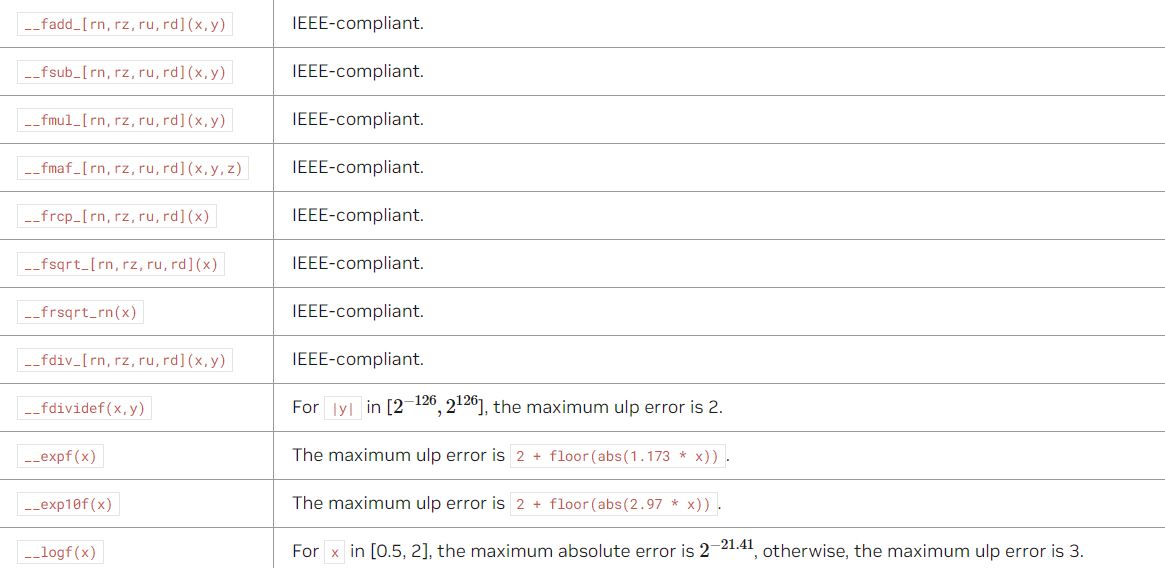

       [CUDA programming guide](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#mathematical-functions-appendix)
            - rn : 반올림
            - rz : 0에 가까운 방향으로 올림/내림
            - ru : 올림
            - rd : 내림
      - ex) _fmul_rn 은 단정밀도로 곱셈을 수행하며 반올림 방식으로 라운딩을 수행하는 함수임
   




```
for(int i=0; i<k; i++){
      val+=__fmul_rn(matA[row*k+i],matB[i*n+col]);
  }
```

- 이와 같이 수정하면 CPU와 동일한 결과를 얻을 것임

In [8]:
%%cuda
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <chrono>
#include <iostream>

#define DO_CPU
#define DATA_TYPE float

#define SIZE_M (512*2)
#define SIZE_N (512*4)
#define SIZE_K (512*2)

template<class T> void allocNinitMem(T** p, long long size, double* memUsage = NULL);
bool compareMatrix(DATA_TYPE* _A, DATA_TYPE* _B, int _size);

/******************************************************************
* Complete this kernels
******************************************************************/
__global__ void MatMul(DATA_TYPE* matA, DATA_TYPE* matB, DATA_TYPE* matC, int m, int n, int k)
{
  unsigned int row = blockIdx.x*blockDim.x+threadIdx.x;
  unsigned int col = blockIdx.y*blockDim.y+threadIdx.y;

	if(col>=n||row>=m) return;
	DATA_TYPE val = 0;
  for(int i=0; i<k; i++){
      val+=__fmul_rn(matA[row*k+i],matB[i*n+col]);
  }
	matC[row*n + col] = val;

}


int main(int argc, char* argv[])
{

	// set matrix size
	int m, n, k;
	m = SIZE_M;
	n = SIZE_N;
	k = SIZE_K;

	printf("Size : A = (%d by %d), B = (%d by %d), C = (%d by %d)\n", m, k, k, n, m, n);

	int sizeA = m * k;
	int sizeB = k * n;
	int sizeC = m * n;

	// Make matrix
	DATA_TYPE* A = NULL, * B = NULL;
	allocNinitMem<DATA_TYPE>(&A, sizeA);
	allocNinitMem<DATA_TYPE>(&B, sizeB);

	DATA_TYPE* Ccpu = NULL, * Cgpu = NULL;
	allocNinitMem<DATA_TYPE>(&Ccpu, sizeC);
	allocNinitMem<DATA_TYPE>(&Cgpu, sizeC);

	// generate input matrices
	for (int i = 0; i < sizeA; i++) A[i] = ((rand() % 10) + ((rand() % 100) / 100.0));
	for (int i = 0; i < sizeB; i++) B[i] = ((rand() % 10) + ((rand() % 100) / 100.0));

	// CPU algorithm
	auto hostStart = std::chrono::high_resolution_clock::now();
	for (int row = 0; row < m; row++) {
		for (int col = 0; col < n; col++) {
			int cIndex = row * n + col;
			Ccpu[cIndex] = 0;
			for (int i = 0; i < k; i++)
				Ccpu[cIndex] += (A[row * k + i] * B[i * n + col]);
		}
	}
	printf("CPU finished!\n");
	auto hostEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> hostElapsed = hostEnd - hostStart;

	/******************************************************************
	* Write your codes for GPU algorithm from here
	******************************************************************/
	DATA_TYPE* dA, * dB, * dC;

	// 1. Allocate device memory for dA, dB, dC
	// Hint: cudaMalloc, cudaMemset
  cudaMalloc(&dA, sizeof(DATA_TYPE)*sizeA); cudaMemset(dA, 0, sizeof(DATA_TYPE)*sizeA);
  cudaMalloc(&dB, sizeof(DATA_TYPE)*sizeB); cudaMemset(dB, 0, sizeof(DATA_TYPE)*sizeB);
  cudaMalloc(&dC, sizeof(DATA_TYPE)*sizeC); cudaMemset(dC, 0, sizeof(DATA_TYPE)*sizeC);
	auto GPUStart = std::chrono::high_resolution_clock::now();

	auto h2dStart = std::chrono::high_resolution_clock::now();

	// 2. Send(Copy) the input matrices to GPU (A -> dB, B -> dB)
	// Hint: cudaMemcpy
  cudaMemcpy(dA, A, sizeof(DATA_TYPE)*sizeA, cudaMemcpyHostToDevice);
  cudaMemcpy(dB, B, sizeof(DATA_TYPE)*sizeB, cudaMemcpyHostToDevice);

	auto h2dEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> h2dElapsed = h2dEnd - h2dStart;

	// 3. Set the thread layout
	//
	dim3 gridDim(ceil((float)SIZE_M/8), ceil((float)SIZE_N/8));
	dim3 blockDim(8, 8);

	printf("Grid(%d, %d), Block(%d, %d)\n", gridDim.x, gridDim.y, blockDim.x, blockDim.y);

	auto kernelStart = std::chrono::high_resolution_clock::now();

	// 4. Kernel call
	MatMul <<< gridDim, blockDim >>> (dA, dB, dC, m, n, k);

	cudaDeviceSynchronize(); // this is synchronization for mearusing the kernel processing time
	auto kernelEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> kernelElapsed = kernelEnd - kernelStart;

	auto d2hStart = std::chrono::high_resolution_clock::now();

	//5. Get(copy) the result from GPU to host memory (dC -> Cgpu)
	// Hint: cudaMemcpy
  cudaMemcpy(Cgpu, dC, sizeC* sizeof(DATA_TYPE), cudaMemcpyDeviceToHost);

	auto d2hEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> d2hElapsed = d2hEnd - d2hStart;

 auto GPUEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> GPUElapsed = GPUEnd - GPUStart;

  std::cout << "Host time: " << hostElapsed.count() << " ms" << std::endl;
  std::cout<<"Host -> Device: " << h2dElapsed.count() << " ms" << std::endl;
  std::cout<<"Kernel: " << kernelElapsed.count() << " ms" << std::endl;
  std::cout<<"Device -> Host: " << d2hElapsed.count() << " ms" << std::endl;
  std::cout << "GPU time: " << GPUElapsed.count() << " ms" << std::endl;
	// 6. Release device memory space (dA, dB, dC)
	// Hint: cudaFree
  cudaFree(dA);
  cudaFree(dB);
  cudaFree(dC);


	/******************************************************************
	******************************************************************/


	compareMatrix(Ccpu, Cgpu, sizeC);

	delete A;
	delete B;
	delete Ccpu;
	delete Cgpu;

	return 0;
}


// Utility functions
bool compareMatrix(DATA_TYPE* _A, DATA_TYPE* _B, int _size)
{
	bool isMatched = true;
	for (int i = 0; i < _size; i++) {
		if (_A[i] != _B[i]) {
			printf("[%d] not matched! (%f, %f)\n", i, (double)_A[i], (double)_B[i]);
			getchar();
			isMatched = false;
		}
	}
	if (isMatched)
		printf("Results are matched!\n");
	else
		printf("Results are not matched!!!!!!!!!!!\n");

	return isMatched;
}

template<class T>
void allocNinitMem(T** p, long long size, double* memUsage) {
	*p = new T[size];
	memset(*p, 0, sizeof(T) * size);

	if (memUsage != NULL) {
		*memUsage += sizeof(T) * size;
	}
}

Size : A = (1024 by 1024), B = (1024 by 2048), C = (1024 by 2048)
CPU finished!
Grid(128, 256), Block(8, 8)
Host time: 20321.1 ms
Host -> Device: 2.85917 ms
Kernel: 52.0438 ms
Device -> Host: 2.08298 ms
GPU time: 56.9899 ms
Results are matched!

